In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime
import requests
import math
plt.rcParams["font.family"] = "Garamond"

## Function

In [2]:
def data_conso_meteo(annee_min, annee_max=None, region="Provence-Alpes-Côte d'Azur"):
    warnings.filterwarnings("ignore")
    if annee_max == None:
        annees = [annee_min]
    else:
        annees = [an for an in np.arange(annee_min, annee_max + 1)]
    
    df_meteo = pd.read_csv(r"data/donnees-synop-essentielles-omm.csv", sep=";")
    df_meteo["Date"] =  pd.to_datetime(df_meteo["Date"], utc=True)  # Conversion en date
    df_meteo = df_meteo[df_meteo.Date.dt.year.isin(annees)]      #Filtre 2015-2019
    df_meteo = df_meteo.loc[df_meteo["region (name)"] == region, :]       # FIltre PACA

    # Aggregation de la région (moyennes)
    df_temp = df_meteo.groupby("Date")["Température (°C)"].mean()
    df_vent = df_meteo.groupby("Date")["Vitesse du vent moyen 10 mn"].mean()
    df_humid = df_meteo.groupby("Date")["Humidité"].mean()
    df_precip = df_meteo.groupby("Date")["Précipitations dans les 3 dernières heures"].mean()
    df_meteo_reg = pd.concat([df_temp, df_vent, df_humid, df_precip], axis=1)

    #journalier
    df_meteo_paca_jour = df_meteo_reg.resample('D').mean()
    df_meteo_paca_jour["Tempé_max"] = df_meteo_reg.resample('D').max()["Température (°C)"]
    df_meteo_paca_jour["Tempé_min"] = df_meteo_reg.resample('D').min()["Température (°C)"]
    df_meteo_paca_jour["Tdj"] = (df_meteo_paca_jour.Tempé_max + df_meteo_paca_jour.Tempé_min)/2
    df_meteo_paca_jour["DJ17"] = df_meteo_paca_jour["Tdj"].apply(lambda x: (x < 17) * (17 - x))  # Calcul DJ
    
    df_meteo_paca_jour['Date'] = pd.to_datetime(df_meteo_paca_jour.index)
    # Extraire les dates sans l'heure
    df_meteo_paca_jour['Date'] = df_meteo_paca_jour['Date'].dt.date
    # Réindexer le DataFrame avec les nouvelles dates
    df_meteo_paca_jour.set_index('Date', inplace=True)
    df_meteo_paca_jour["Précipitations dans les 3 dernières heures"] = df_meteo_paca_jour["Précipitations dans les 3 dernières heures"] * 8   # jour = 24h = 3*8
    df_meteo_paca_jour.rename(columns = {"Précipitations dans les 3 dernières heures": "Précipitations (mm)"}, inplace=True)


    df_conso = pd.read_csv("data/consommation-quotidienne-brute-regionale.csv", sep=";")
    df_conso["Date - Heure"] = pd.to_datetime(df_conso["Date - Heure"])
    df_conso = df_conso.loc[df_conso["Région"] == region, :].sort_values(by = "Date - Heure")   # FIltre PACA
    # Filtre année
    df_conso = df_conso[df_conso["Date - Heure"].astype("str").str.contains("|".join(map(str, annees)))]
    # journalier
    df_conso_elec = df_conso.groupby("Date")["Consommation brute électricité (MW) - RTE"].sum()
    df_conso_gaz = df_conso.groupby("Date")["Consommation brute gaz totale (MW PCS 0°C)"].sum()
    df_conso_paca_jour = pd.concat([df_conso_elec, df_conso_gaz], axis=1)
    # MW to MWh
    df_conso_paca_jour["Consommation brute électricité (MW) - RTE"] = df_conso_paca_jour["Consommation brute électricité (MW) - RTE"] / 2
    # weekday
    df_conso_paca_jour["Date"] = pd.to_datetime(df_conso_paca_jour.index)
    df_conso_paca_jour["WeekDay"] = df_conso_paca_jour.Date.dt.day_name().map({"Monday": "Lundi", "Tuesday": "Mardi", "Wednesday": "Mercredi", "Thursday": "Jeudi", "Friday": "Vendredi", "Saturday": "Samedi", "Sunday": "Dimanche"})
    df_conso_paca_jour.drop("Date", axis=1, inplace = True)
    
    df_final = pd.merge(df_meteo_paca_jour.reset_index(), df_conso_paca_jour.reset_index(drop=True), left_index= True, right_index = True)
    
    return df_final

In [3]:
def data_conso_meteo_res(annee_min, annee_max=None, region="Provence-Alpes-Côte d'Azur"):
    warnings.filterwarnings("ignore")
    if annee_max == None:
        annees = [annee_min]
    else:
        annees = [an for an in np.arange(annee_min, annee_max + 1)]
    
    df_meteo = pd.read_csv(r"data/donnees-synop-essentielles-omm.csv", sep=";")
    df_meteo["Date"] =  pd.to_datetime(df_meteo["Date"], utc=True)  # Conversion en date
    df_meteo = df_meteo[df_meteo.Date.dt.year.isin(annees)]      #Filtre 2015-2019
    df_meteo = df_meteo.loc[df_meteo["region (name)"] == region, :]       # FIltre PACA

    # Aggregation de la région (moyennes)
    df_temp = df_meteo.groupby("Date")["Température (°C)"].mean()
    df_vent = df_meteo.groupby("Date")["Vitesse du vent moyen 10 mn"].mean()
    df_humid = df_meteo.groupby("Date")["Humidité"].mean()
    df_precip = df_meteo.groupby("Date")["Précipitations dans les 3 dernières heures"].mean()
    df_meteo_reg = pd.concat([df_temp, df_vent, df_humid, df_precip], axis=1)

    #journalier
    df_meteo_paca_jour = df_meteo_reg.resample('D').mean()
    df_meteo_paca_jour["Tempé_max"] = df_meteo_reg.resample('D').max()["Température (°C)"]
    df_meteo_paca_jour["Tempé_min"] = df_meteo_reg.resample('D').min()["Température (°C)"]
    df_meteo_paca_jour["Tdj"] = (df_meteo_paca_jour.Tempé_max + df_meteo_paca_jour.Tempé_min)/2
    df_meteo_paca_jour["DJ17"] = df_meteo_paca_jour["Tdj"].apply(lambda x: (x < 17) * (17 - x))  # Calcul DJ
    
    df_meteo_paca_jour['Date'] = pd.to_datetime(df_meteo_paca_jour.index)
    # Extraire les dates sans l'heure
    df_meteo_paca_jour['Date'] = df_meteo_paca_jour['Date'].dt.date
    # Réindexer le DataFrame avec les nouvelles dates
    df_meteo_paca_jour.set_index('Date', inplace=True)
    df_meteo_paca_jour["Précipitations dans les 3 dernières heures"] = df_meteo_paca_jour["Précipitations dans les 3 dernières heures"] * 8   # jour = 24h = 3*8
    df_meteo_paca_jour.rename(columns = {"Précipitations dans les 3 dernières heures": "Précipitations (mm)"}, inplace=True)

    #CONSO
    url = "https://data.enedis.fr/api/explore/v2.1/catalog/datasets/conso-inf36-region/records"
    # Requests parameters
    days_delay = 0  
    params = {
        "select": "sum(total_energie_soutiree_wh) / 1000000 AS energie_soutiree_mwh",
        "where": """region = "Provence-Alpes-Côte d\'Azur" and startswith(profil, 'RES')""",
        "group_by": "date_format(horodate, 'YYYY-MM-dd') as Date",
        "order_by": "Date DESC",
        "limit": 100,  # Limit of rows, max is 100. 96 is the number of rows for 1 city for 1 day
        "offset": days_delay     # Offset = 96 * 3 metropoles = 288, since we are fetching data for the previous day
    }
    n_days = 731
    n_requests = math.ceil(n_days / 100)
    all_records = []
    for _ in range(n_requests):                     # 10 requests
        response = requests.get(url, params=params)
        if response.status_code == 200:     # Success
            data = response.json()
            records = data['results']
            all_records.extend(records)     # Add this request to the results
            
            params["offset"] += params["limit"]    # Shift for the next request
        else:
            print("Échec de la requête :", response.status_code)
            break
    # Create DataFrame from the collected records
    paca_res_df = pd.DataFrame(all_records)
    paca_res_df = paca_res_df[0 : n_days]   # to get precisely n_days days
    paca_res_df["Date"] = pd.to_datetime(paca_res_df["Date"])
    # days of week
    days_of_week = {0: 'Lundi', 1: 'Mardi', 2: 'Mercredi', 3: 'Jeudi', 4: 'Vendredi', 5: 'Samedi', 6: 'Dimanche'}
    paca_res_df["WeekDay"] = paca_res_df["Date"].dt.day_of_week.map(days_of_week)
    paca_res_df.set_index("Date", inplace = True)
    
    df_final = pd.merge(df_meteo_paca_jour.reset_index(), paca_res_df.reset_index(drop=True), left_index= True, right_index = True)
    
    return df_final

In [4]:
# API endpoint
url = "https://data.enedis.fr/api/explore/v2.1/catalog/datasets/conso-inf36-region/records"

# Requests parameters
days_delay = 0  
params = {
    "select": "sum(total_energie_soutiree_wh) / 1000000 AS energie_soutiree_mwh",
    "where": """region = "Provence-Alpes-Côte d\'Azur" and startswith(profil, 'RES')""",
    "group_by": "date_format(horodate, 'YYYY-MM-dd') as Date",
    "order_by": "Date DESC",
    "limit": 100,  # Limit of rows, max is 100. 96 is the number of rows for 1 city for 1 day
    "offset": days_delay     # Offset = 96 * 3 metropoles = 288, since we are fetching data for the previous day
}

n_days = 731
n_requests = math.ceil(n_days / 100)
all_records = []
for _ in range(n_requests):                     # 10 requests
    response = requests.get(url, params=params)
    if response.status_code == 200:     # Success
        data = response.json()
        records = data['results']
        all_records.extend(records)     # Add this request to the results
        
        params["offset"] += params["limit"]    # Shift for the next request
    else:
        print("Échec de la requête :", response.status_code)
        break

# Create DataFrame from the collected records
paca_res_df = pd.DataFrame(all_records)
paca_res_df = paca_res_df[0 : n_days]   # to get precisely n_days days
paca_res_df["Date"] = pd.to_datetime(paca_res_df["Date"])

days_of_week = {0: 'Lundi', 1: 'Mardi', 2: 'Mercredi', 3: 'Jeudi', 4: 'Vendredi', 5: 'Samedi', 6: 'Dimanche'}
paca_res_df["WeekDay"] = paca_res_df["Date"].dt.day_of_week.map(days_of_week)
paca_res_df.set_index("Date", inplace = True)

In [5]:
def plot_nuage(data, region, var_meteo, var_conso, annee_min, annee_max, intervalles = [(0, 17), (21, 30)], method = "pearson"):

    # Création du graphe
    plt.rcParams["font.family"] = "Garamond"
    fig, ax = plt.subplots(figsize=(9, 6))
    if var_meteo == "Température (°C)":
    # Nuage de points
        sns.scatterplot(data=data, x=var_meteo, y=var_conso, hue=var_meteo, palette="coolwarm", legend=None)
    elif var_meteo == "DJ17":
        sns.scatterplot(data=data, x=var_meteo, y=var_conso, hue=var_meteo, palette=sns.dark_palette("#69d", reverse=False, as_cmap=True), legend=None)    
    else:
        sns.scatterplot(data=data, x=var_meteo, y=var_conso, legend=None)
            

    # Régressions linéaires sur les intervalles définis
    for intervalle in intervalles:
        x_intervalle = np.arange(intervalle[0], intervalle[1])
        sns.regplot(data=data[(data[var_meteo] >= intervalle[0]) & (data[var_meteo] <= intervalle[1])], x=var_meteo, y=var_conso, scatter=False, ax=ax, color="dimgrey", scatter_kws={"s": 1})

    # Calcul et affichage de la corrélation
    for intervalle in intervalles:
        data_intervalle = data[(data[var_meteo] >= intervalle[0]) & (data[var_meteo] <= intervalle[1])]
        correlation = data_intervalle[var_meteo].corr(data_intervalle[var_conso], method= method)
        plt.text(x=data_intervalle[var_meteo].max() + 1, y=data_intervalle[var_conso].min() - 15000, s=f'Corrélation: {correlation:.2f}', fontsize=8, color='black')

    # Paramètres du graphe
    plt.title(f'Relation entre {var_meteo} et {var_conso}', weight="bold")
    if annee_max == None :
        plt.suptitle(f"Champ : {region}, {annee_min}", fontsize=9)
    else:    
        plt.suptitle(f"Champ : {region}, {annee_min}-{annee_max if annee_max else annee_min}", fontsize=9)
    plt.xlabel(var_meteo)
    plt.ylabel(var_conso)
    plt.text(x=-6, y=data[var_conso].min() - 32000, s='Source : OPENDATA RESEAUX-ENERGIES, Données SYNOP essentielles OMM', fontsize=8, color='black')
    plt.tight_layout()
    plt.show()

In [6]:
import matplotlib.dates as mdates

def timeplot_lines(data, region, var_meteo, var_conso, annee_min, annee_max, degre = 10):  
    
    #Reprocess données : sur 1 seule année graphiquement
    data["Date"] = pd.to_datetime(data["Date"])
    data["Date"] = data["Date"].apply(lambda x: x.replace(year=2016))
    data.sort_values(by= "Date", inplace = True)        # re_sort
    data = data[~((data['Date'].dt.month == 2) & (data['Date'].dt.day == 29))]      # removing 29th february
    
    #Abcisses
    if annee_max == None:
        n_an = 1
    else:
        n_an = annee_max - annee_min + 1    
    x = np.arange(1, 366)
    x = np.repeat(x, n_an)
    
    
    fig, ax1 = plt.subplots(figsize = (13, 8))
    # Tracer le nuage de points pour la consommation d'électricité avec une échelle à gauche
    sns.scatterplot(data=data, x=x, y=var_conso, ax=ax1, color='blue', alpha = 0.2)
    ax1.set_ylabel(var_conso, color='blue', fontsize = 12)
    sns.regplot(data=data, x = x, y = var_conso, ax = ax1, order = 10, scatter = False, color = "blue")

    # Ajouter une deuxième échelle à droite pour la température
    ax2 = ax1.twinx()
    sns.scatterplot(data=data, x=x, y=var_meteo, ax=ax2, color='red', alpha = 0.2)
    ax2.set_ylabel(var_meteo, color='red', fontsize = 12)
    sns.regplot(data=data, x=x, y=var_meteo, ax=ax2, order = 10, scatter = False, color='red')

    ax1.set_xlabel("Mois de l'année")
    plt.title(f'{var_conso} et {var_meteo}', weight = 'bold')
    if annee_max == None:
        plt.suptitle(f"Champ : {region}, {annee_min}", fontsize=10) 
    else:    
        plt.suptitle(f"Champ : {region}, {annee_min}-{annee_max if annee_max else annee_min}", fontsize=10)
    plt.text(x= -20, y= -3, s='Source : OPENDATA RESEAUX-ENERGIES, Données SYNOP essentielles OMM', fontsize=8, color='black')

    # Formatter les étiquettes des mois
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b'))  # %b pour les abbréviations des mois
    ax1.xaxis.set_major_locator(mdates.MonthLocator())  # Afficher les étiquettes pour chaque mois
    plt.xticks(rotation=45)  # Rotation des étiquettes pour une meilleure lisibilité
    
    plt.tight_layout()
    plt.show()

In [7]:
def main(annee_min, annee_max=None, region="Provence-Alpes-Côte d'Azur", var_meteo="Température (°C)", var_conso="Consommation brute électricité (MW) - RTE", return_df=False, timeplot=False): 
    df_final = data_conso_meteo(annee_min, annee_max, region)
    plot_nuage(df_final, region, var_meteo, var_conso, annee_min=annee_min, annee_max=annee_max)
    if timeplot:
        timeplot_lines(df_final, region, var_meteo, var_conso, annee_min, annee_max)
    
    if return_df:
        return df_final

## Historique code

In [8]:
df_meteo0 = pd.read_csv(r"C:\Users\thibaud.genel\Downloads\donnees-synop-essentielles-omm.csv", sep=";")
df_meteo0.tail()

,ID OMM station,Date,Pression au niveau mer,Variation de pression en 3 heures,Type de tendance barométrique,Direction du vent moyen 10 mn,Vitesse du vent moyen 10 mn,Température,Point de rosée,Humidité,...,Altitude,communes (name),communes (code),EPCI (name),EPCI (code),department (name),department (code),region (name),region (code),mois_de_l_annee
1681013,7790,2020-04-09T23:00:00+02:00,102250.0,110.0,0.0,200.0,1.6,282.75,277.75,71.0,...,10,Lucciana,2B148,CC de Marana-Golo,200036499.0,Haute-Corse,2B,Corse,94.0,4
1681014,61998,2020-04-09T23:00:00+02:00,100820.0,70.0,3.0,290.0,2.6,277.45,272.05,68.0,...,29,Archipel des Kerguelen,98412,NaN,NaN,Terres australes et antarctiques françaises,984,Terres australes et antarctiques françaises,984.0,4
1681015,7471,2020-04-10T02:00:00+02:00,NaN,0.0,4.0,250.0,1.2,276.85,272.05,71.0,...,833,Chaspuzac,43062,CA du Puy-en-Velay,200073419.0,Haute-Loire,43,Auvergne-Rhône-Alpes,84.0,4
1681016,7591,2020-04-10T05:00:00+02:00,NaN,-20.0,8.0,160.0,0.5,278.95,270.35,54.0,...,871,Embrun,05046,CC Serre-Ponçon,200067742.0,Hautes-Alpes,05,Provence-Alpes-Côte d'Azur,93.0,4
1681017,7761,2020-04-10T05:00:00+02:00,102300.0,0.0,5.0,60.0,3.0,279.55,275.25,74.0,...,5,Ajaccio,2A004,CA du Pays Ajaccien,242010056.0,Corse-du-Sud,2A,Corse,94.0,4


In [9]:
df_meteo0.shape

(1681018, 82)

In [10]:
df_meteo = df_meteo0.copy()

df_meteo["Date"] =  pd.to_datetime(df_meteo["Date"], utc=True)  # Conversion en date
df_meteo = df_meteo[df_meteo.Date.dt.year.isin([2016, 2017, 2018, 2019])]      #Filtre 2015-2019
df_meteo.shape

(656362, 82)

In [11]:
df_meteo = df_meteo.loc[df_meteo["region (name)"] == "Provence-Alpes-Côte d'Azur", :]       # FIltre PACA
df_meteo.shape

(45156, 82)

In [12]:
df_meteo.sort_values(by="Date").head()

,ID OMM station,Date,Pression au niveau mer,Variation de pression en 3 heures,Type de tendance barométrique,Direction du vent moyen 10 mn,Vitesse du vent moyen 10 mn,Température,Point de rosée,Humidité,...,Altitude,communes (name),communes (code),EPCI (name),EPCI (code),department (name),department (code),region (name),region (code),mois_de_l_annee
604271,7690,2016-01-01 00:00:00+00:00,102590.0,-60.0,8.0,330.0,3.1,282.75,277.75,71.0,...,2,Nice,06088,Métropole Nice Côte d'Azur,200030195.0,Alpes-Maritimes,06,Provence-Alpes-Côte d'Azur,93.0,1
935788,7591,2016-01-01 00:00:00+00:00,NaN,0.0,0.0,40.0,2.6,274.55,271.45,80.0,...,871,Embrun,05046,CC Serre-Ponçon,200067742.0,Hautes-Alpes,05,Provence-Alpes-Côte d'Azur,93.0,1
472678,7661,2016-01-01 00:00:00+00:00,102560.0,-40.0,8.0,70.0,4.1,283.05,280.95,87.0,...,115,Saint-Mandrier-sur-Mer,83153,Métropole Toulon-Provence-Méditerranée,248300543.0,Var,83,Provence-Alpes-Côte d'Azur,93.0,1
1161233,7650,2016-01-01 00:00:00+00:00,102550.0,-40.0,8.0,190.0,1.7,283.25,282.15,93.0,...,9,Marignane,13054,Métropole d'Aix-Marseille-Provence,200054807.0,Bouches-du-Rhône,13,Provence-Alpes-Côte d'Azur,93.0,1
1253541,7591,2016-01-01 03:00:00+00:00,NaN,0.0,4.0,30.0,3.6,275.45,271.65,76.0,...,871,Embrun,05046,CC Serre-Ponçon,200067742.0,Hautes-Alpes,05,Provence-Alpes-Côte d'Azur,93.0,1


In [13]:
# Aggregation de la région (moyennes)

df_temp = df_meteo.groupby("Date")["Température (°C)"].mean()
df_vent = df_meteo.groupby("Date")["Vitesse du vent moyen 10 mn"].mean()
df_humid = df_meteo.groupby("Date")["Humidité"].mean()
df_precip = df_meteo.groupby("Date")["Précipitations dans les 3 dernières heures"].mean()

df_meteo_reg = pd.concat([df_temp, df_vent, df_humid, df_precip], axis=1)
df_meteo_reg.head()

,Température (°C),Vitesse du vent moyen 10 mn,Humidité,Précipitations dans les 3 dernières heures
Date,,,,
2016-01-01 00:00:00+00:00,7.750,2.875,82.75,-0.025
2016-01-01 03:00:00+00:00,7.675,2.925,83.50,0.050
2016-01-01 06:00:00+00:00,7.050,3.925,81.25,0.000
2016-01-01 09:00:00+00:00,8.750,3.000,77.00,0.000
2016-01-01 12:00:00+00:00,12.000,3.150,64.25,0.000


In [14]:
#journalier
df_meteo_paca_jour = df_meteo_reg.resample('D').mean()
df_meteo_paca_jour['Date'] = pd.to_datetime(df_meteo_paca_jour.index)
# Extraire les dates sans l'heure
df_meteo_paca_jour['Date'] = df_meteo_paca_jour['Date'].dt.date
# Réindexer le DataFrame avec les nouvelles dates
df_meteo_paca_jour.set_index('Date', inplace=True)

df_meteo_paca_jour["Précipitations dans les 3 dernières heures"] = df_meteo_paca_jour["Précipitations dans les 3 dernières heures"] * 8   # jour = 24h = 3*8
df_meteo_paca_jour.rename(columns = {"Précipitations dans les 3 dernières heures": "Précipitations (mm)"}, inplace=True)
df_meteo_paca_jour.head()

,Température (°C),Vitesse du vent moyen 10 mn,Humidité,Précipitations (mm)
Date,,,,
2016-01-01,9.240625,3.465625,76.56250,0.825
2016-01-02,9.050000,4.971875,88.03125,11.675
2016-01-03,7.296875,4.384375,73.71875,0.275
2016-01-04,8.553125,3.815625,79.12500,4.000
2016-01-05,8.250000,3.768750,79.12500,0.625


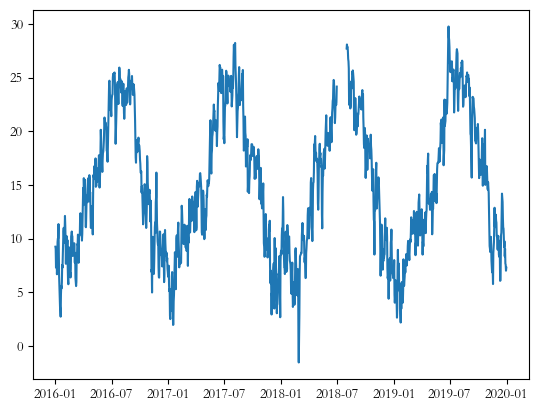

In [15]:
plt.plot(df_meteo_paca_jour.index, df_meteo_paca_jour["Température (°C)"])

In [16]:
# COnso

df_conso0 = pd.read_csv("data/consommation-quotidienne-brute-regionale.csv", sep=";")
print(df_conso0.shape)
df_conso0.head()

(2348340, 13)


,Date - Heure,Date,Heure,Code INSEE région,Région,Consommation brute gaz (MW PCS 0°C) - GRTgaz,Statut - GRTgaz,Consommation brute gaz (MW PCS 0°C) - Teréga,Statut - Teréga,Consommation brute gaz totale (MW PCS 0°C),Consommation brute électricité (MW) - RTE,Statut - RTE,Consommation brute totale (MW)
0,2013-05-19T21:30:00+02:00,2013-05-19,21:30,76,Occitanie,NaN,NaN,NaN,NaN,NaN,3454,Définitif,NaN
1,2013-05-19T22:00:00+02:00,2013-05-19,22:00,27,Bourgogne-Franche-Comté,1543.0,Définitif,NaN,NaN,1543.0,2287,Définitif,3830.0
2,2013-05-19T22:00:00+02:00,2013-05-19,22:00,53,Bretagne,973.0,Définitif,NaN,NaN,973.0,2047,Définitif,3020.0
3,2013-05-19T22:30:00+02:00,2013-05-19,22:30,84,Auvergne-Rhône-Alpes,NaN,NaN,NaN,NaN,NaN,6595,Définitif,NaN
4,2013-05-19T23:00:00+02:00,2013-05-19,23:00,76,Occitanie,374.0,Définitif,1069.0,Définitif,1443.0,4326,Définitif,5769.0


In [17]:
df_conso = df_conso0.copy()
df_conso["Date - Heure"] = pd.to_datetime(df_conso["Date - Heure"])
df_conso["Date"] = pd.to_datetime(df_conso["Date"])
df_conso["WeekDay"] = df_conso["Date"].dt.day_name().map({"Monday": "Lundi", "Tuesday": "Mardi", "Wednesday": "Mercredi", "Thursday": "Jeudi", "Friday": "Vendredi", "Saturday": "Samedi", "Sunday": "Dimanche"})

df_conso = df_conso.loc[df_conso["Région"] == "Provence-Alpes-Côte d'Azur", :].sort_values(by = "Date - Heure")   # FIltre PACA
print(df_conso.shape)
df_conso.head()

C:\Users\thibaud.genel\AppData\Local\Temp\ipykernel_11912\1875825423.py:2: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df_conso["Date - Heure"] = pd.to_datetime(df_conso["Date - Heure"])


(195695, 14)


,Date - Heure,Date,Heure,Code INSEE région,Région,Consommation brute gaz (MW PCS 0°C) - GRTgaz,Statut - GRTgaz,Consommation brute gaz (MW PCS 0°C) - Teréga,Statut - Teréga,Consommation brute gaz totale (MW PCS 0°C),Consommation brute électricité (MW) - RTE,Statut - RTE,Consommation brute totale (MW),WeekDay
1251401,2013-01-01 00:30:00+01:00,2013-01-01,00:30,93,Provence-Alpes-Côte d'Azur,NaN,NaN,NaN,NaN,NaN,5570,Définitif,NaN,Mardi
170617,2013-01-01 01:00:00+01:00,2013-01-01,01:00,93,Provence-Alpes-Côte d'Azur,NaN,NaN,NaN,NaN,NaN,5698,Définitif,NaN,Mardi
1232460,2013-01-01 01:30:00+01:00,2013-01-01,01:30,93,Provence-Alpes-Côte d'Azur,NaN,NaN,NaN,NaN,NaN,5680,Définitif,NaN,Mardi
6659,2013-01-01 02:00:00+01:00,2013-01-01,02:00,93,Provence-Alpes-Côte d'Azur,NaN,NaN,NaN,NaN,NaN,5577,Définitif,NaN,Mardi
1232475,2013-01-01 02:30:00+01:00,2013-01-01,02:30,93,Provence-Alpes-Côte d'Azur,NaN,NaN,NaN,NaN,NaN,5711,Définitif,NaN,Mardi


In [18]:
# Filtre 2019
df_conso = df_conso[df_conso["Date - Heure"].astype("str").str.contains("^(2016|2017|2018|2019)")]
print(df_conso.shape)
df_conso.head()

C:\Users\thibaud.genel\AppData\Local\Temp\ipykernel_11912\1357853513.py:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df_conso = df_conso[df_conso["Date - Heure"].astype("str").str.contains("^(2016|2017|2018|2019)")]


(70128, 14)


,Date - Heure,Date,Heure,Code INSEE région,Région,Consommation brute gaz (MW PCS 0°C) - GRTgaz,Statut - GRTgaz,Consommation brute gaz (MW PCS 0°C) - Teréga,Statut - Teréga,Consommation brute gaz totale (MW PCS 0°C),Consommation brute électricité (MW) - RTE,Statut - RTE,Consommation brute totale (MW),WeekDay
1208590,2016-01-01 00:00:00+01:00,2016-01-01,00:00,93,Provence-Alpes-Côte d'Azur,3831.0,Définitif,NaN,NaN,3831.0,5858,Définitif,9689.0,Vendredi
1416511,2016-01-01 00:30:00+01:00,2016-01-01,00:30,93,Provence-Alpes-Côte d'Azur,NaN,NaN,NaN,NaN,NaN,5477,Définitif,NaN,Vendredi
646427,2016-01-01 01:00:00+01:00,2016-01-01,01:00,93,Provence-Alpes-Côte d'Azur,3682.0,Définitif,NaN,NaN,3682.0,5278,Définitif,8960.0,Vendredi
646432,2016-01-01 01:30:00+01:00,2016-01-01,01:30,93,Provence-Alpes-Côte d'Azur,NaN,NaN,NaN,NaN,NaN,5262,Définitif,NaN,Vendredi
1416561,2016-01-01 02:00:00+01:00,2016-01-01,02:00,93,Provence-Alpes-Côte d'Azur,3700.0,Définitif,NaN,NaN,3700.0,5154,Définitif,8854.0,Vendredi


In [19]:
# journalier
df_conso_paca_jour = pd.DataFrame(df_conso.groupby("Date")["Consommation brute électricité (MW) - RTE"].sum())
df_conso_paca_jour

,Consommation brute électricité (MW) - RTE
Date,
2016-01-01,238843
2016-01-02,246101
2016-01-03,254255
2016-01-04,272288
2016-01-05,276222
...,...
2019-12-27,254661
2019-12-28,256434
2019-12-29,255259


In [20]:
df_final = pd.merge(df_meteo_paca_jour.reset_index(), df_conso_paca_jour.reset_index(drop=True), left_index= True, right_index = True)
df_final

,Date,Température (°C),Vitesse du vent moyen 10 mn,Humidité,Précipitations (mm),Consommation brute électricité (MW) - RTE
0,2016-01-01,9.240625,3.465625,76.56250,0.825,238843
1,2016-01-02,9.050000,4.971875,88.03125,11.675,246101
2,2016-01-03,7.296875,4.384375,73.71875,0.275,254255
3,2016-01-04,8.553125,3.815625,79.12500,4.000,272288
4,2016-01-05,8.250000,3.768750,79.12500,0.625,276222
...,...,...,...,...,...,...
1456,2019-12-27,9.056250,5.609375,66.31250,-0.025,254661
1457,2019-12-28,7.671875,2.518750,71.25000,0.000,256434
1458,2019-12-29,7.559375,2.528125,75.59375,0.050,255259
1459,2019-12-30,7.006250,2.293750,75.68750,0.050,269180


In [21]:
df_final.drop("Date", axis=1).corr()

,Température (°C),Vitesse du vent moyen 10 mn,Humidité,Précipitations (mm),Consommation brute électricité (MW) - RTE
Température (°C),1.000000,-0.172397,-0.243037,-0.113378,-0.764031
Vitesse du vent moyen 10 mn,-0.172397,1.000000,-0.186049,0.244808,0.105302
Humidité,-0.243037,-0.186049,1.000000,0.432812,0.094880
Précipitations (mm),-0.113378,0.244808,0.432812,1.000000,0.040905
Consommation brute électricité (MW) - RTE,-0.764031,0.105302,0.094880,0.040905,1.000000


In [22]:
# Idee de methode: groupby int(température), puis dès que plus de diff significative sur la moyenne, fin chauffage
# ! pip install scipy
import scipy.stats as stats

data = df_final.copy()
# Calculer les intervalles de température
intervalles = pd.interval_range(start=5, end=30, freq=1)

# Ajouter une colonne d'intervalle à votre DataFrame
data["intervalle"] = pd.cut(data["Température (°C)"], bins=intervalles)

# Effectuer un test t de Student entre les groupes de température adjacents
p_values = []
for i in range(len(intervalles) - 1):
    groupe1 = data[data['intervalle'] == intervalles[i]]['Consommation brute électricité (MW) - RTE']
    groupe2 = data[data['intervalle'] == intervalles[i + 1]]['Consommation brute électricité (MW) - RTE']
    _, p_value = stats.ttest_ind(groupe1, groupe2)
    p_values.append(p_value)

# Identifier le moment où les différences de consommation d'électricité deviennent non significatives
seuil_significativite = 0.01  # Seuil de significativité à ajuster selon vos besoins
moment_fin_chauffage = None
for i, p_value in enumerate(p_values):
    if p_value > seuil_significativite:
        moment_fin_chauffage = intervalles[i + 1]
        break

print("Le moment où les gens cessent de chauffer est probablement autour de :", moment_fin_chauffage)


Le moment où les gens cessent de chauffer est probablement autour de : (16, 17]


In [23]:
import scipy.stats as stats

data = df_final.copy()
# Calculer les intervalles de température
intervalles = pd.interval_range(start=5, end=30, freq=1)

# Ajouter une colonne d'intervalle à votre DataFrame
data["intervalle"] = pd.cut(data["Température (°C)"], bins=intervalles)

# Effectuer un test t de Student entre les groupes de température adjacents
p_values = []
for i in range(len(intervalles) - 1):
    groupe1 = data[data['intervalle'] == intervalles[i]]['Consommation brute électricité (MW) - RTE']
    groupe2 = data[data['intervalle'] == intervalles[i + 1]]['Consommation brute électricité (MW) - RTE']
    _, p_value = stats.ttest_ind(groupe1, groupe2)
    p_values.append(p_value)

# Identifier le moment où les différences de consommation d'électricité deviennent non significatives
seuil_significativite = 0.01  # Seuil de significativité à ajuster selon vos besoins
moment_fin_clim = None
p_values.reverse() #sens inverse
for i, p_value in enumerate(p_values):  
    if p_value > seuil_significativite:
        moment_fin_clim = intervalles[i + 1]
        break

print("Le moment où les gens cessent de climer est probablement autour de :", moment_fin_clim)


Le moment où les gens cessent de climer est probablement autour de : (6, 7]


In [24]:
import scipy.stats as stats

data = df_final.copy()
# Calculer les intervalles de température
intervalles = pd.interval_range(start=10, end=2, freq=1)

# Ajouter une colonne d'intervalle à votre DataFrame
data["intervalle"] = pd.cut(data["Température (°C)"], bins=intervalles)

# Effectuer un test t de Student entre les groupes de température adjacents
p_values = []
for i in range(len(intervalles) - 1, 0, -1):
    groupe1 = data[data['intervalle'] == intervalles[i]]['Consommation brute électricité (MW) - RTE']
    groupe2 = data[data['intervalle'] == intervalles[i - 1]]['Consommation brute électricité (MW) - RTE']
    _, p_value = stats.ttest_ind(groupe1, groupe2)
    p_values.append(p_value)

# Identifier le moment où les différences de consommation d'électricité deviennent non significatives
seuil_significativite = 0.01  # Seuil de significativité à ajuster selon vos besoins
moment_fin_climatisation = None
for i, p_value in enumerate(p_values):
    if p_value > seuil_significativite:
        moment_fin_climatisation = intervalles[len(intervalles) - i - 1]
        break

print("Le moment où les gens cessent de mettre la climatisation est probablement autour de :", moment_fin_climatisation)


Le moment où les gens cessent de mettre la climatisation est probablement autour de : None


## Use

In [25]:
annee_min = 2021
annee_max = 2023
region = "Provence-Alpes-Côte d'Azur"

In [26]:
df_1 = data_conso_meteo(2023)
df_1

,Date,Température (°C),Vitesse du vent moyen 10 mn,Humidité,Précipitations (mm),Tempé_max,Tempé_min,Tdj,DJ17,Consommation brute électricité (MW) - RTE,Consommation brute gaz totale (MW PCS 0°C),WeekDay
0,2023-01-01,12.312500,4.062500,82.166667,0.000000,14.433333,10.766667,12.600000,4.400000,99842.5,75814.0,Dimanche
1,2023-01-02,11.425000,4.703125,76.208333,0.000000,15.066667,9.366667,12.216667,4.783333,107446.0,96156.0,Lundi
2,2023-01-03,10.587500,2.353125,84.250000,0.133333,13.266667,8.833333,11.050000,5.950000,111577.5,116415.0,Mardi
3,2023-01-04,8.579167,2.963542,81.125000,-0.033333,14.200000,5.500000,9.850000,7.150000,116622.5,86905.0,Mercredi
4,2023-01-05,9.204167,2.962500,76.604167,0.000000,14.233333,5.100000,9.666667,7.333333,117786.0,100180.0,Jeudi
...,...,...,...,...,...,...,...,...,...,...,...,...
360,2023-12-27,8.333333,3.546875,67.000000,-0.033333,13.966667,4.900000,9.433333,7.566667,122466.5,91252.0,Mercredi
361,2023-12-28,8.312500,3.450000,71.041667,0.000000,11.966667,5.933333,8.950000,8.050000,121221.5,87787.0,Jeudi
362,2023-12-29,8.050000,2.353125,73.750000,-0.033333,10.700000,5.700000,8.200000,8.800000,119131.0,87203.0,Vendredi
363,2023-12-30,8.050000,2.990625,76.291667,-0.033333,12.433333,4.400000,8.416667,8.583333,114562.5,141119.0,Samedi


In [27]:
df_5 = data_conso_meteo(annee_min, annee_max)
df_5

,Date,Température (°C),Vitesse du vent moyen 10 mn,Humidité,Précipitations (mm),Tempé_max,Tempé_min,Tdj,DJ17,Consommation brute électricité (MW) - RTE,Consommation brute gaz totale (MW PCS 0°C),WeekDay
0,2021-01-01,5.016667,5.321875,82.041667,9.233333,5.800000,4.133333,4.966667,12.033333,141907.5,156529.0,Vendredi
1,2021-01-02,4.825000,5.718750,76.500000,11.433333,5.766667,3.800000,4.783333,12.216667,147078.5,184623.0,Samedi
2,2021-01-03,3.575000,5.362500,81.416667,5.133333,6.066667,1.966667,4.016667,12.983333,148212.0,170310.0,Dimanche
3,2021-01-04,3.325000,3.928125,79.458333,3.633333,5.066667,2.100000,3.583333,13.416667,160213.0,227163.0,Lundi
4,2021-01-05,2.258333,2.753125,84.166667,0.400000,4.666667,0.733333,2.700000,14.300000,163776.5,232297.0,Mardi
...,...,...,...,...,...,...,...,...,...,...,...,...
1090,2023-12-27,8.333333,3.546875,67.000000,-0.033333,13.966667,4.900000,9.433333,7.566667,122466.5,91252.0,Mercredi
1091,2023-12-28,8.312500,3.450000,71.041667,0.000000,11.966667,5.933333,8.950000,8.050000,121221.5,87787.0,Jeudi
1092,2023-12-29,8.050000,2.353125,73.750000,-0.033333,10.700000,5.700000,8.200000,8.800000,119131.0,87203.0,Vendredi
1093,2023-12-30,8.050000,2.990625,76.291667,-0.033333,12.433333,4.400000,8.416667,8.583333,114562.5,141119.0,Samedi


In [28]:
# Export
df_5.to_csv("conso_meteo.csv")

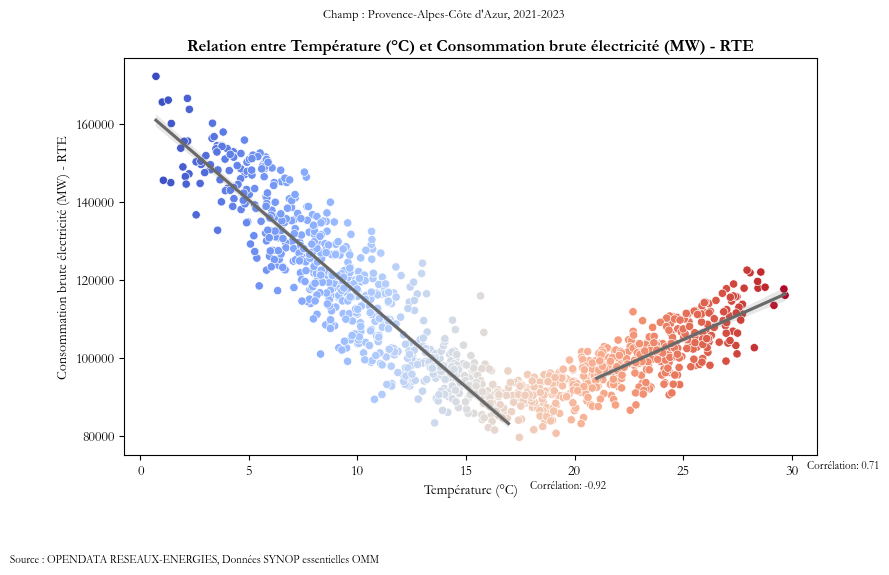

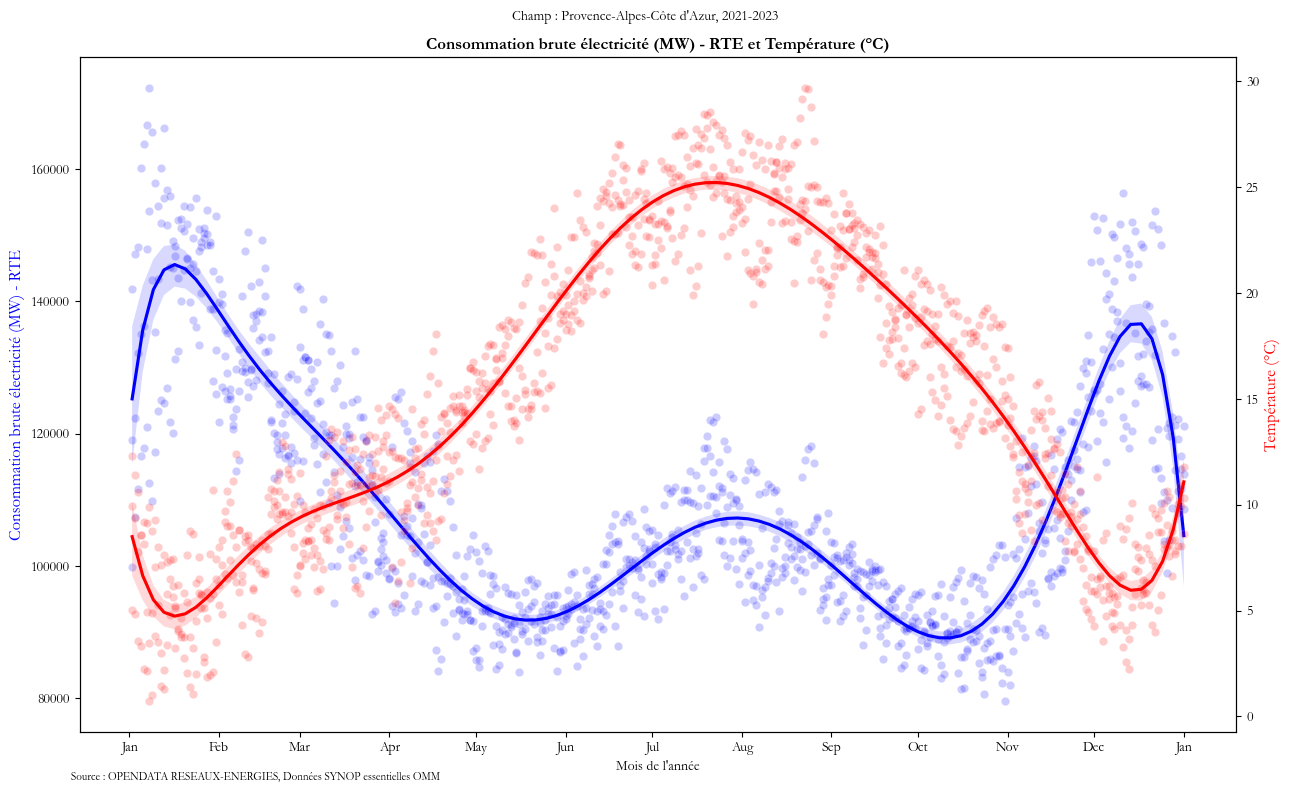

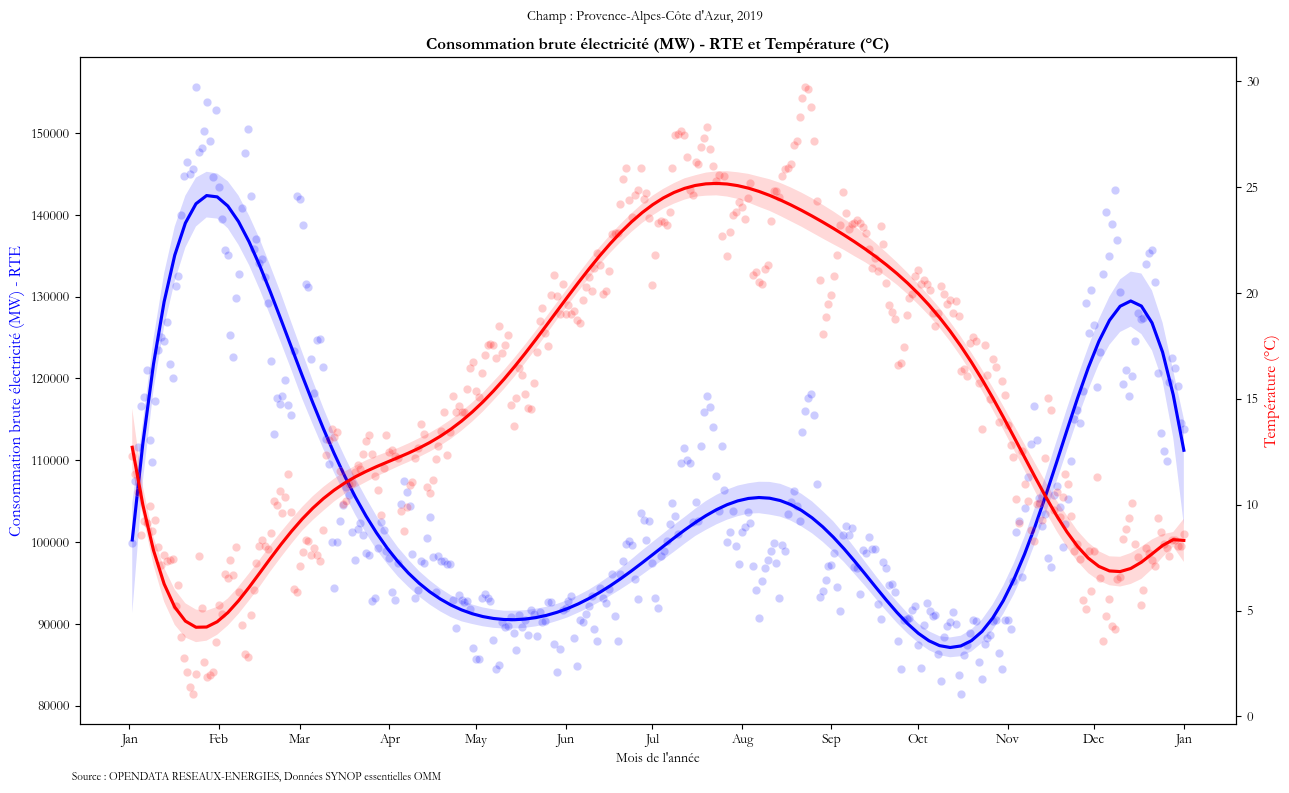

In [29]:
var_meteo = "Température (°C)"
var_conso = "Consommation brute électricité (MW) - RTE" 
# var_conso = "Consommation brute gaz totale (MW PCS 0°C)"

plot_nuage(df_5, region, var_meteo, var_conso, annee_min, annee_max)
timeplot_lines(df_5, region, var_meteo, var_conso, annee_min, annee_max)
timeplot_lines(df_1, region, var_meteo, var_conso, annee_min=2019, annee_max=None)

posx and posy should be finite values
posx and posy should be finite values


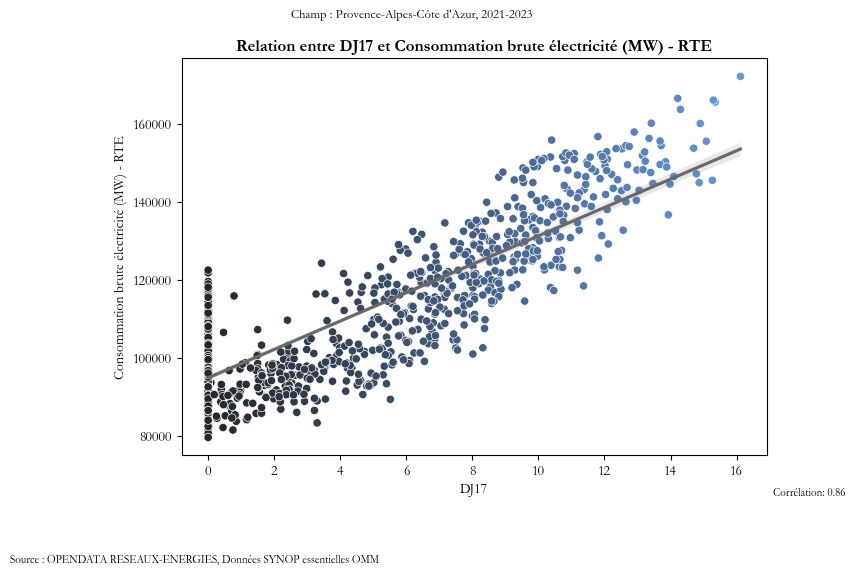

In [30]:
var_meteo = "DJ17"
var_conso = "Consommation brute électricité (MW) - RTE" 
# var_conso = "Consommation brute gaz totale (MW PCS 0°C)"

plot_nuage(df_5, region, var_meteo, var_conso, annee_min, annee_max)

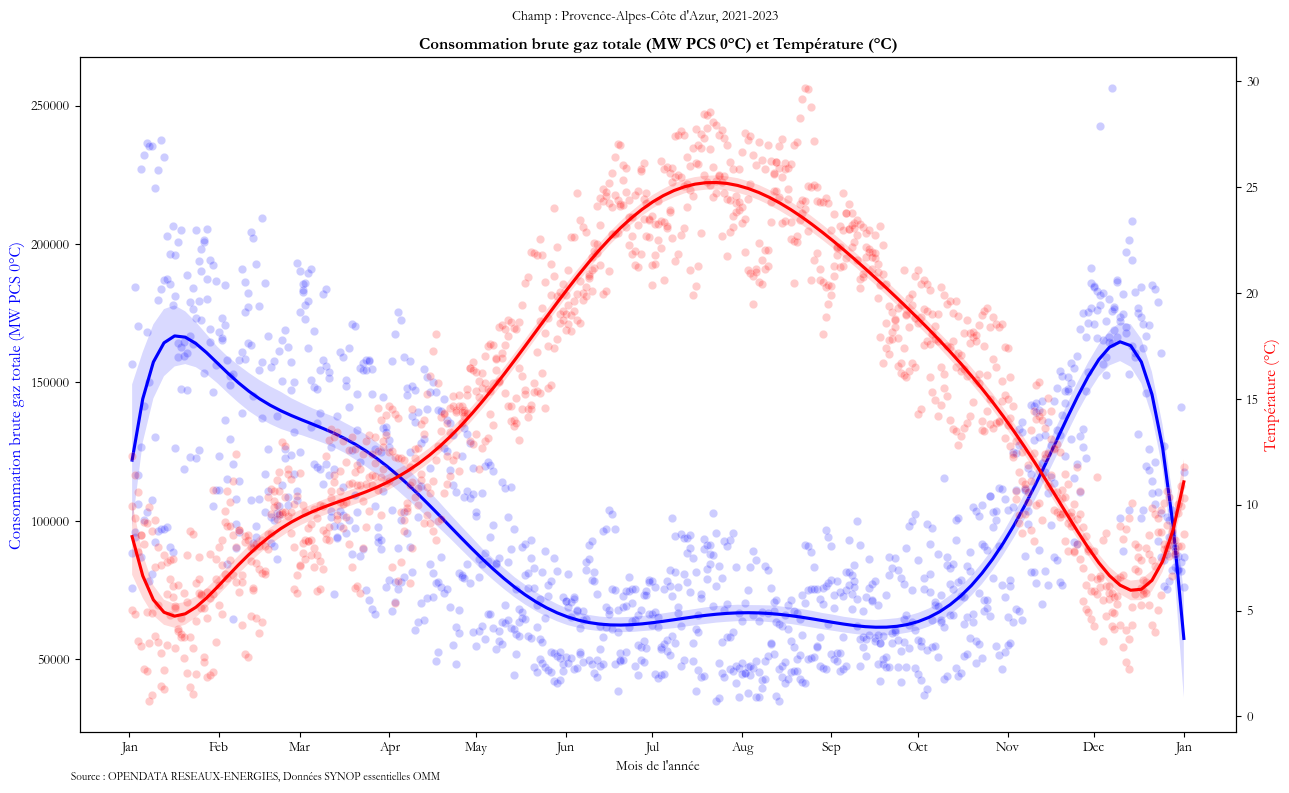

In [31]:
annee_min, annee_max = 2021, 2023
var_meteo = "Température (°C)"
# var_conso = "Consommation brute électricité (MW) - RTE" 
var_conso = "Consommation brute gaz totale (MW PCS 0°C)"

timeplot_lines(df_5, region, var_meteo, var_conso, annee_min, annee_max)

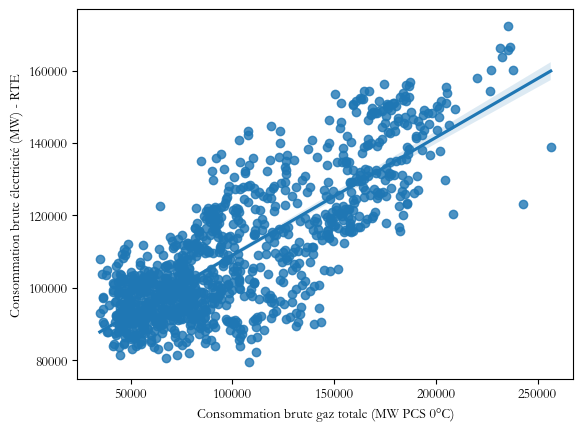

0.7199293821976008


In [32]:
sns.regplot(data = df_5, x = "Consommation brute gaz totale (MW PCS 0°C)", y = "Consommation brute électricité (MW) - RTE")
plt.show()
print(df_5["Consommation brute électricité (MW) - RTE"].corr(df_5["Consommation brute gaz totale (MW PCS 0°C)"], method="spearman"))

In [33]:
annee_min = 2013
annee_max = 2023
region = "Provence-Alpes-Côte d'Azur"

df_11 = data_conso_meteo(annee_min, annee_max)

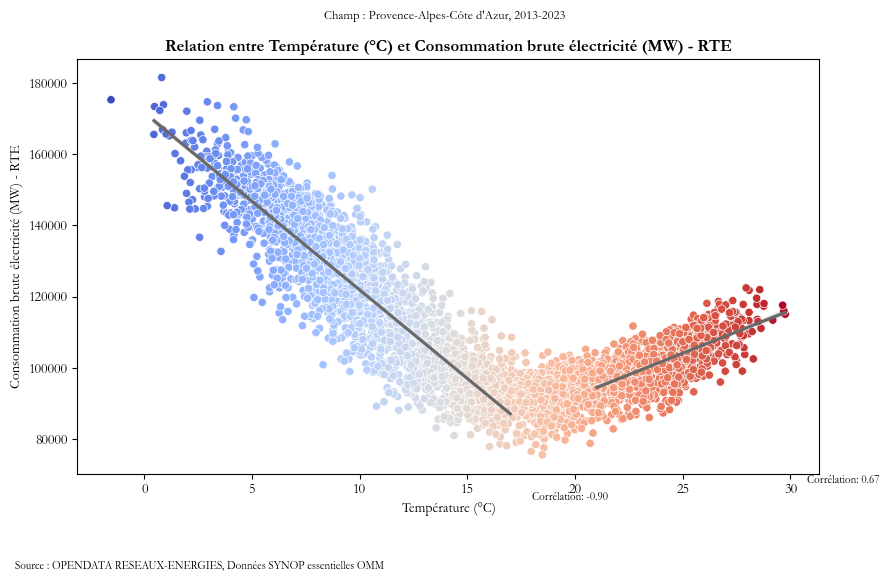

In [34]:
var_meteo = "Température (°C)"
var_conso = "Consommation brute électricité (MW) - RTE" 
# var_conso = "Consommation brute gaz totale (MW PCS 0°C)"

plot_nuage(df_11, region, var_meteo, var_conso, 2013, 2023)

In [35]:
df_11.to_csv("meteo_conso.csv")

In [36]:
df_11 = pd.read_csv("meteo_conso.csv")
df_11[df_11["Température (°C)"] > 21]["Température (°C)"].median()

23.884375000000027

## Modelisation 

In [37]:
annee_min = 2013
annee_max = 2023
region = "Provence-Alpes-Côte d'Azur"
habs_paca = 5057000     # 5160000 1er janvier 2023, INSEE, 4 954 000 en 2013

df_mod = data_conso_meteo(annee_min, annee_max)

In [38]:
df_mod.head()

,Date,Température (°C),Vitesse du vent moyen 10 mn,Humidité,Précipitations (mm),Tempé_max,Tempé_min,Tdj,DJ17,Consommation brute électricité (MW) - RTE,Consommation brute gaz totale (MW PCS 0°C),WeekDay
0,2013-01-01,6.537500,4.184375,76.93750,4.15,7.875,5.275,6.5750,10.4250,126185.5,89031.0,Mardi
1,2013-01-02,7.059375,4.003125,72.06250,1.75,9.800,5.125,7.4625,9.5375,140032.0,127685.0,Mercredi
2,2013-01-03,6.915625,3.600000,60.90625,0.00,11.425,4.500,7.9625,9.0375,142763.0,139064.0,Jeudi
3,2013-01-04,6.209375,2.362500,70.59375,0.00,11.800,2.625,7.2125,9.7875,143399.5,131493.0,Vendredi
4,2013-01-05,7.200000,2.475000,75.25000,0.00,11.825,4.000,7.9125,9.0875,133924.0,118698.0,Samedi


In [39]:
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
import joblib
# ! pip install sklearn
from sklearn.model_selection import train_test_split

df_mod['Date'] = pd.to_datetime(df_mod['Date'])
df_mod['WeekDay'] = df_mod['Date'].dt.weekday
data = df_mod.dropna(subset = ["Température (°C)"])
X = data[["Température (°C)", "WeekDay"]]
y = data["Consommation brute électricité (MW) - RTE"]
# SPLIT DATA
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 5)
train_d = pd.merge(X_train, y_train, left_index=True, right_index=True)
train_by_weekday = {i: train_d[train_d['WeekDay'] == i] for i in range(7)} # Séparation des données par jour de la semaine
test_d = pd.merge(X_test, y_test, left_index=True, right_index=True)
test_by_weekday = {i: test_d[test_d['WeekDay'] == i] for i in range(7)} # Séparation des données par jour de la semaine

In [40]:
# TRAIN
best_degrees = {}
models = {}

for day in range(7):
    data = train_by_weekday[day]
    X_day = data[['Température (°C)']]
    y_day = data['Consommation brute électricité (MW) - RTE']
    
    best_score = float('inf')
    best_degree = 1
    
    for degree in range(1, 10):  # Tester les degrés de 1 à 9
        model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
        scores = cross_val_score(model, X_day, y_day, scoring='neg_mean_squared_error', cv=5)
        score = -scores.mean()
        
        if score < best_score:
            best_score = score
            best_degree = degree
    
    best_degrees[day] = best_degree
    models[day] = make_pipeline(PolynomialFeatures(best_degree), LinearRegression())
    models[day].fit(X_day, y_day)

# Afficher le meilleur degré pour chaque jour
days_of_week = {0: 'Lundi', 1: 'Mardi', 2: 'Mercredi', 3: 'Jeudi', 4: 'Vendredi', 5: 'Samedi', 6: 'Dimanche'}
print("Best degrees by day of the week:", {days_of_week[day]: degree for day, degree in best_degrees.items()})


Best degrees by day of the week: {'Lundi': 5, 'Mardi': 7, 'Mercredi': 6, 'Jeudi': 6, 'Vendredi': 6, 'Samedi': 4, 'Dimanche': 4}


In [41]:
# TEST
for day in range(7):
    data = test_by_weekday[day]
    X_day = data[['Température (°C)']]
    y_day = data['Consommation brute électricité (MW) - RTE']
    
    y_pred = models[day].predict(X_day)
    rmse = np.sqrt(mean_squared_error(y_day, y_pred))
    print(f'{days_of_week[day]}, Degree {best_degrees[day]}, RMSE: {rmse}')


Lundi, Degree 5, RMSE: 6653.695521129166
Mardi, Degree 7, RMSE: 6554.574065643943
Mercredi, Degree 6, RMSE: 7244.127345454164
Jeudi, Degree 6, RMSE: 6303.93046820308
Vendredi, Degree 6, RMSE: 6831.398420324328
Samedi, Degree 4, RMSE: 6880.854582443699
Dimanche, Degree 4, RMSE: 5681.137337724259


In [42]:
# SAVE
import joblib

for day in range(7): 
    joblib.dump(models[day], f'models/model{day}.pkl')

In [43]:
# GRAPHES
# fig, axs = plt.subplots(4, 2, figsize=(15, 20))
# fig.tight_layout(pad=5.0)

# for day in range(7):
#     row = day // 2
#     col = day % 2
#     data = test_by_weekday[day]
#     X_day = data[['Température (°C)']]
#     y_day = data['Consommation brute électricité (MW) - RTE']
    
#     # Prédictions pour la courbe du modèle
#     X_fit = np.linspace(X_day['Température (°C)'].min(), X_day['Température (°C)'].max(), 100).reshape(-1, 1)
#     y_fit = models[day].predict(X_fit)
    
#     # Tracer les points de test et la courbe du modèle
#     axs[row, col].scatter(X_day, y_day, color='blue', label='Données test')
#     axs[row, col].plot(X_fit, y_fit, color='red', label=f'Modèle (degré {best_degrees[day]})')
#     axs[row, col].set_title(days_of_week[day])
#     axs[row, col].set_xlabel('Température (°C)')
#     axs[row, col].set_ylabel('Consommation brute électricité (MW)')
#     axs[row, col].legend()

# # Supprimer le dernier sous-graphe vide
# fig.delaxes(axs[3, 1])

# plt.show()

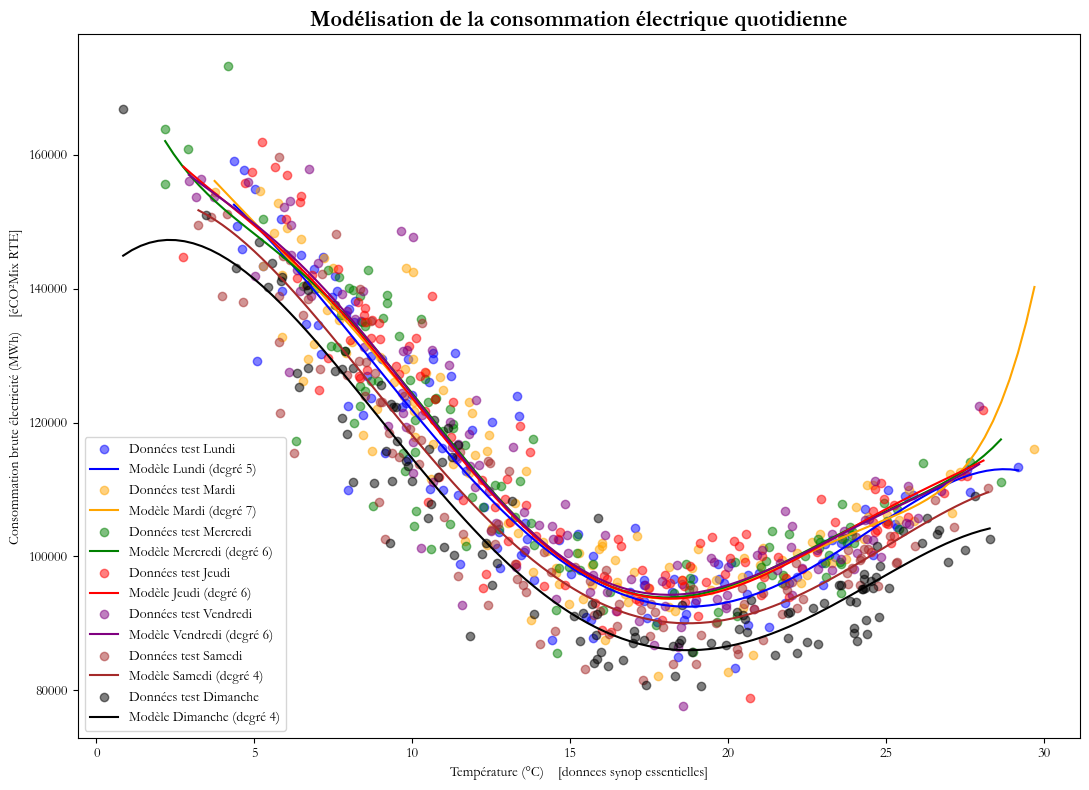

In [44]:
# Création d'un seul graphique
plt.figure(figsize=(11, 8))

colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'black']

for day in range(7):
    data = test_by_weekday[day]
    X_day = data[['Température (°C)']]
    y_day = data['Consommation brute électricité (MW) - RTE']
    
    # Prédictions pour la courbe du modèle
    X_fit = np.linspace(X_day['Température (°C)'].min(), X_day['Température (°C)'].max(), 100).reshape(-1, 1)
    y_fit = models[day].predict(X_fit)
    
    # Tracer les points de test et la courbe du modèle
    plt.scatter(X_day, y_day, color=colors[day], label=f'Données test {days_of_week[day]}', alpha=0.5)
    plt.plot(X_fit, y_fit, color=colors[day], label=f'Modèle {days_of_week[day]} (degré {best_degrees[day]})')

plt.title('Modélisation de la consommation électrique quotidienne', weight = 'bold', fontsize = 16)
plt.xlabel('Température (°C)    [donnees synop essentielles]')
plt.ylabel('Consommation brute électricité (MWh)    [éCO²Mix RTE]')
plt.legend()
plt.tight_layout()
plt.show()

In [45]:
def conso0_paca(tempe, wday):
    """Returns estimated value for Electric Consumption according to a temperature value, based on a Polynomial Regression (degree 7).

    Args:
        tempe (float): Temperature in °C

    Returns:
        float: Estimated value of consumption
    """
    if isinstance(wday, str):
        wday_reverse = {'lundi':0, 'mardi':1, 'mercredi':2, 'jeudi':3, 'vendredi':4, 'samedi':5, 'dimanche':6}
        day = wday_reverse[wday]
    else : # int
        day = wday
        
    x = np.array([[tempe]])
    return np.round(models[day].predict(x)[0], 2)

conso0_paca(tempe = 10, wday = 6)

114603.4

In [46]:
import joblib

def polyn_paca(model):
    # Extraire les coefficients et l'intercept
    intercept = model.named_steps['linearregression'].intercept_
    coefficients = model.named_steps['linearregression'].coef_

    # Créer la formule de régression
    formula = f'{intercept:.2f} '
    for i, coef in enumerate(coefficients):
        if i != 0:
            formula += f'+ ({coef} * tempe**{i})'
    return formula

for day in range(7):
    # Charger le modèle à partir du fichier pkl
    model = joblib.load(f'models/model{day}.pkl')
    print(f"conso {days_of_week[day]} = ", polyn_paca(model))



conso Lundi =  162833.69 + (-10.1829097165942 * tempe**1)+ (-620.8913209596785 * tempe**2)+ (15.173836774209013 * tempe**3)+ (0.8361893500078418 * tempe**4)+ (-0.023835039496863976 * tempe**5)
conso Mardi =  173528.40 + (-3207.1133922879685 * tempe**1)+ (-941.5478321839163 * tempe**2)+ (234.57825473993933 * tempe**3)+ (-29.284900669928557 * tempe**4)+ (1.8172842602197978 * tempe**5)+ (-0.052995753141384855 * tempe**6)+ (0.0005843030485579255 * tempe**7)
conso Mercredi =  190385.94 + (-20442.27801345836 * tempe**1)+ (4484.063321619279 * tempe**2)+ (-562.5690549541175 * tempe**3)+ (33.565668740164334 * tempe**4)+ (-0.9282875552265284 * tempe**5)+ (0.00970246435555825 * tempe**6)
conso Jeudi =  176290.82 + (-10514.392911209909 * tempe**1)+ (2150.0275130328046 * tempe**2)+ (-309.52847609598325 * tempe**3)+ (19.63143483948526 * tempe**4)+ (-0.5496060531316305 * tempe**5)+ (0.005672948625714985 * tempe**6)
conso Vendredi =  174459.22 + (-10230.327292294094 * tempe**1)+ (2280.0748352652013 * 

In [47]:
tempe = 25
conso =  162833.69 + (-10.1829097165942 * tempe**1)+ (-620.8913209596785 * tempe**2)+ (15.173836774209013 * tempe**3)+ (0.8361893500078418 * tempe**4)+ (-0.023835039496863976 * tempe**5)
conso

105485.64851455283

In [48]:
conso0_paca(25, wday = 0)

105485.65

In [49]:
# D'AUTRES MODELES ?
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

rmses = []
for day in range(7):
    train_d = train_by_weekday[day]
    X_train = train_d["Température (°C)"]
    y_train = train_d["Consommation brute électricité (MW) - RTE"]
    test_d = test_by_weekday[day]
    X_test = test_d["Température (°C)"]
    y_test = test_d["Consommation brute électricité (MW) - RTE"]
    
    # Régression par arbre de décision
    tree_model = DecisionTreeRegressor(random_state=21)
    tree_model.fit(X_train.values.reshape(-1, 1), y_train)
    tree_y_pred = tree_model.predict(X_test.values.reshape(-1, 1))
    tree_rmse = np.sqrt(mean_squared_error(y_test, tree_y_pred))

    # Régression par forêts aléatoires
    rf_model = RandomForestRegressor(random_state=21)
    rf_model.fit(X_train.values.reshape(-1, 1), y_train)
    rf_y_pred = rf_model.predict(X_test.values.reshape(-1, 1))
    rf_rmse = np.sqrt(mean_squared_error(y_test, rf_y_pred))

    # Régression par machine à vecteurs de support (SVM)
    svm_model = SVR(kernel='rbf')
    svm_model.fit(X_train.values.reshape(-1, 1), y_train)
    svm_y_pred = svm_model.predict(X_test.values.reshape(-1, 1))
    svm_rmse = np.sqrt(mean_squared_error(y_test, svm_y_pred))
    
    rmses.append([days_of_week[day], tree_rmse, rf_rmse, svm_rmse])
    
results_df = pd.DataFrame(rmses, columns=['Day', 'Tree', 'Random Forest', 'SVM'])
results_df.set_index('Day')

,Tree,Random Forest,SVM
Day,,,
Lundi,10041.999336,8532.184069,20356.105845
Mardi,8820.187907,7517.783071,18117.426450
Mercredi,10808.673916,9160.766901,20003.661831
Jeudi,8889.005059,7646.781930,19633.842544
Vendredi,10252.280617,8621.026845,20505.695237
Samedi,9201.975256,8130.883701,20105.218134
Dimanche,8366.603678,6833.307519,19117.254722


### Modelisation Edge-Case

Pour les valeurs extrêmes de froid ou de chaud non vues lors de l'entraînement, la régression polynomiale peut faire un peu n'importe quoi. On va donc contrôler ceci en appliquant une régression linéaire, moins capricieuse, pour ces valeurs extrêmes.

Exemple Lundi :
Conso(tempe faible) = 171016.46319417175 + (-4549.346755578752 * tempefaible)
R2 : 0.58


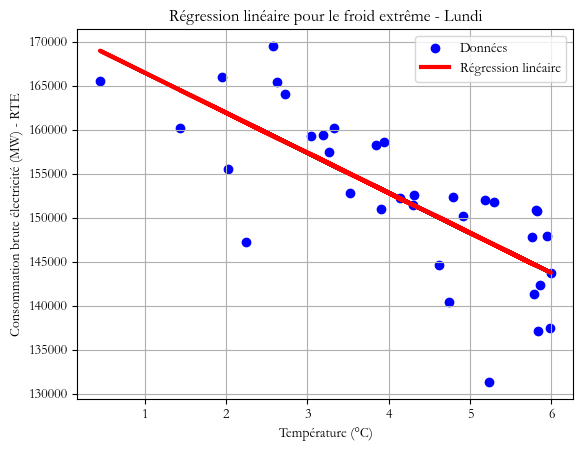

In [50]:
# Sous 1 degré : reg linéaire entraînée sous 6 degrés
from sklearn.linear_model import LinearRegression

seuil_train = 6
lr_froids = {}
for day in range(7):
    data = train_by_weekday[day]
    data = data.loc[data["Température (°C)"] < seuil_train, :] # froid
    X = pd.DataFrame(data["Température (°C)"])
    y = data["Consommation brute électricité (MW) - RTE"]

    lr = LinearRegression()
    lr.fit(X, y)
    lr_froids[day] = lr

dayex = 0
lr1 = lr_froids[dayex] 
data = train_by_weekday[dayex]
data = data.loc[data["Température (°C)"] < seuil_train, :] # froid
X = pd.DataFrame(data["Température (°C)"])
y = data["Consommation brute électricité (MW) - RTE"]  
print(f"Exemple {days_of_week[dayex]} :\nConso(tempe faible) = {lr1.intercept_} + ({lr1.coef_[0]} * tempefaible)")
print(f"R2 : {lr1.score(X, y):.2f}")

# Tracer les points de données
plt.scatter(X, y, color='blue', label='Données')
# Tracer la droite de régression
plt.plot(X, lr1.predict(X), color='red', linewidth=3, label='Régression linéaire')
plt.title(f'Régression linéaire pour le froid extrême - {days_of_week[dayex]}')
plt.xlabel('Température (°C)')
plt.ylabel('Consommation brute électricité (MW) - RTE')
plt.legend()
plt.grid(True)
plt.show()

Exemple Mercredi :
Conso(tempe haute) = 13222.77552227497 + (3691.3608935975444 * tempehaute)
R2 : 0.52


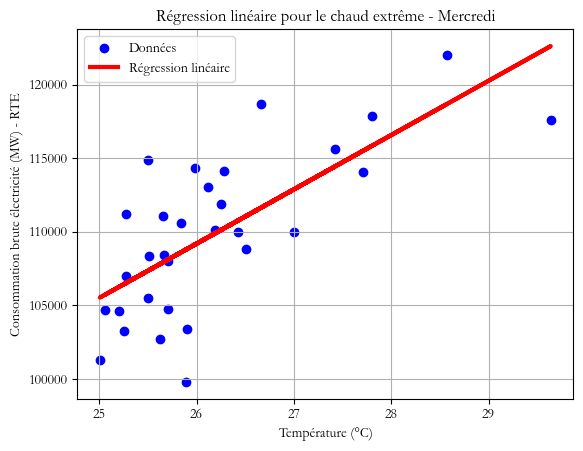

In [51]:
# Au-dessus de 28 degrés : reg linéaire entraînée au-dessus de 23 degrés
from sklearn.linear_model import LinearRegression

seuil_train = 25
lr_chauds= {}
for day in range(7):
    data = train_by_weekday[day]
    data = data.loc[data["Température (°C)"] > seuil_train, :] # chaud
    X = pd.DataFrame(data["Température (°C)"])
    y = data["Consommation brute électricité (MW) - RTE"]

    lr = LinearRegression()
    lr.fit(X, y)
    lr_chauds[day] = lr

dayex = 2
lr1 = lr_chauds[dayex] 
data = train_by_weekday[dayex]
data = data.loc[data["Température (°C)"] > seuil_train, :] # chaud
X = pd.DataFrame(data["Température (°C)"])
y = data["Consommation brute électricité (MW) - RTE"]  
print(f"Exemple {days_of_week[dayex]} :\nConso(tempe haute) = {lr1.intercept_} + ({lr1.coef_[0]} * tempehaute)")
print(f"R2 : {lr1.score(X, y):.2f}")

# Tracer les points de données
plt.scatter(X, y, color='blue', label='Données')
# Tracer la droite de régression
plt.plot(X, lr1.predict(X), color='red', linewidth=3, label='Régression linéaire')
plt.title(f'Régression linéaire pour le chaud extrême - {days_of_week[dayex]}')
plt.xlabel('Température (°C)')
plt.ylabel('Consommation brute électricité (MW) - RTE')
plt.legend()
plt.grid(True)
plt.show()

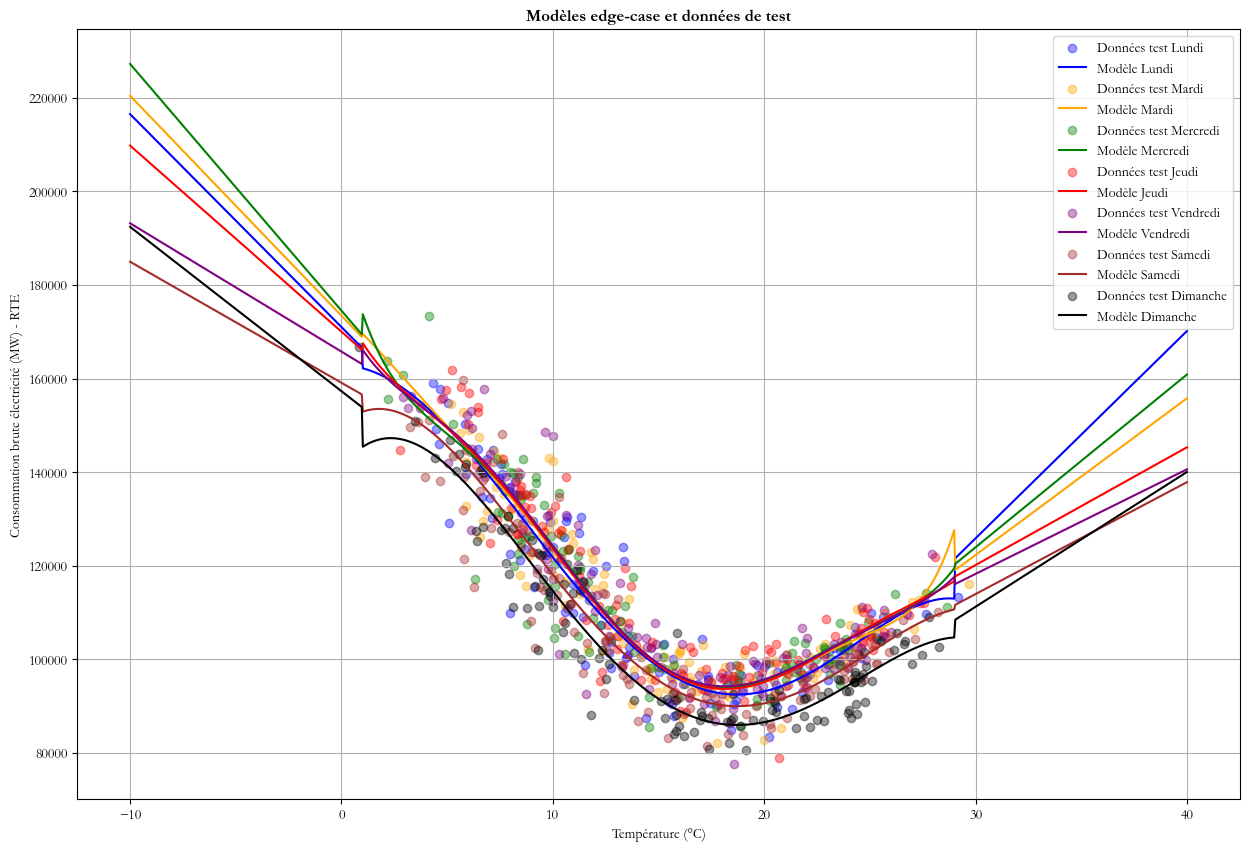

Formule Regression Edge-Case pour Lundi :
ConsoPaca = (tempe < 1) * (171016.46 + (-4549.35 * tempe)) + (tempe >= 1 and tempe < 29) * (162833.69 + (-10.1829097165942 * tempe**1)+ (-620.8913209596785 * tempe**2)+ (15.173836774209013 * tempe**3)+ (0.8361893500078418 * tempe**4)+ (-0.023835039496863976 * tempe**5)) + (tempe >= 29) * (-6984.68 + (4428.87 * tempe))

Formule Regression Edge-Case pour Mardi :
ConsoPaca = (tempe < 1) * (173429.40 + (-4700.92 * tempe)) + (tempe >= 1 and tempe < 29) * (173528.40 + (-3207.1133922879685 * tempe**1)+ (-941.5478321839163 * tempe**2)+ (234.57825473993933 * tempe**3)+ (-29.284900669928557 * tempe**4)+ (1.8172842602197978 * tempe**5)+ (-0.052995753141384855 * tempe**6)+ (0.0005843030485579255 * tempe**7)) + (tempe >= 29) * (21872.72 + (3348.21 * tempe))

Formule Regression Edge-Case pour Mercredi :
ConsoPaca = (tempe < 1) * (174519.36 + (-5272.11 * tempe)) + (tempe >= 1 and tempe < 29) * (190385.94 + (-20442.27801345836 * tempe**1)+ (4484.063321619279 *

In [52]:
# Limites de température
seuil_froid = 1
seuil_chaud = 29

# Définir la fonction conso_paca pour chaque jour
def conso_paca(tempe, day):
    if isinstance(day, str):
        wday_reverse = {'lundi':0, 'mardi':1, 'mercredi':2, 'jeudi':3, 'vendredi':4, 'samedi':5, 'dimanche':6}
        day = wday_reverse[day.lower()]
    else :
        day = day    
        
    if tempe < seuil_froid:
        conso = lr_froids[day].predict([[tempe]])[0]
    elif tempe < seuil_chaud:
        conso = models[day].predict([[tempe]])[0]
    else:  # tempe >= seuil_chaud
        conso = lr_chauds[day].predict([[tempe]])[0]  
    return np.round(conso, 2)

# Préparation des jours de la semaine et des couleurs
days_of_week = {0: 'Lundi', 1: 'Mardi', 2: 'Mercredi', 3: 'Jeudi', 4: 'Vendredi', 5: 'Samedi', 6: 'Dimanche'}
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'black']

# Tracer les points de données de test et les courbes des modèles
plt.figure(figsize=(15, 10))
# Générer des valeurs pour la courbe
temps = np.linspace(-10, 40, 1000)

for day in range(7):
    data = test_by_weekday[day]
    X_day = data[['Température (°C)']]
    y_day = data['Consommation brute électricité (MW) - RTE']
    
    # Tracer les points de test pour chaque jour
    plt.scatter(X_day['Température (°C)'], y_day, color=colors[day], label=f'Données test {days_of_week[day]}', alpha=0.4)
    # Tracer les courbes de modèles
    conso = [conso_paca(t, day) for t in temps]
    plt.plot(temps, conso, color=colors[day], label=f'Modèle {days_of_week[day]}')

plt.title('Modèles edge-case et données de test', weight='bold')
plt.xlabel('Température (°C)')
plt.ylabel('Consommation brute électricité (MW) - RTE')
plt.legend()
plt.grid(True)
plt.show()

# Affichage de la formule de la régression edge-case pour chaque jour
def formule_paca(lr1, lr2, day):
    return f"(tempe < {seuil_froid}) * ({lr1.intercept_:.2f} + ({lr1.coef_[0]:.2f} * tempe)) + " \
           f"(tempe >= {seuil_froid} and tempe < {seuil_chaud}) * ({polyn_paca(models[day])}) + " \
           f"(tempe >= {seuil_chaud}) * ({lr2.intercept_:.2f} + ({lr2.coef_[0]:.2f} * tempe))"

for day in range(7):
    print(f"Formule Regression Edge-Case pour {days_of_week[day]} :\nConsoPaca = {formule_paca(lr_froids[day], lr_chauds[day], day)}\n")

In [53]:
tempe = -10
(tempe < 1) * (157312.30 + (-3511.45 * tempe)) + (tempe >= 1 and tempe < 29) * (141137.86 + (5665.319186016214 * tempe**1)+ (-1466.4511788811192 * tempe**2)+ (74.57353437778615 * tempe**3)+ (-1.1116062932980189 * tempe**4)) + (tempe >= 29) * (24862.23 + (2879.74 * tempe))


192426.8

In [54]:
conso_paca(-10, "dimanche")

192426.77

In [55]:
def formulesql_paca(lr1, model, lr2):
    # Extraire les coefficients et l'intercept
    intercept = model.named_steps['linearregression'].intercept_
    coefficients = model.named_steps['linearregression'].coef_

    # Créer la formule de régression
    polynome = f'{intercept:.2f} '
    for i, coef in enumerate(coefficients):
        if i != 0:
            polynome += f'+ ({coef} * POW(Temperature, {i}))'
    return f"\n     CASE WHEN Temperature < {seuil_froid} THEN ({lr1.intercept_} + ({lr1.coef_[0]} * Temperature)) * part_conso_metropole\n         WHEN Temperature BETWEEN {seuil_froid} and {seuil_chaud} THEN ({polynome}) * part_conso_metropole \n         ELSE ({lr2.intercept_} + ({lr2.coef_[0]} * Temperature)) * part_conso_metropole \n     END"

for day in range(7):
    print(f"WHEN WeekDay = \'{days_of_week[day]}\' THEN",formulesql_paca(lr_froids[day], models[day], lr_chauds[day]))

WHEN WeekDay = 'Lundi' THEN 
     CASE WHEN Temperature < 1 THEN (171016.46319417175 + (-4549.346755578752 * Temperature)) * part_conso_metropole
         WHEN Temperature BETWEEN 1 and 29 THEN (162833.69 + (-10.1829097165942 * POW(Temperature, 1))+ (-620.8913209596785 * POW(Temperature, 2))+ (15.173836774209013 * POW(Temperature, 3))+ (0.8361893500078418 * POW(Temperature, 4))+ (-0.023835039496863976 * POW(Temperature, 5))) * part_conso_metropole 
         ELSE (-6984.68089434749 + (4428.874027658534 * Temperature)) * part_conso_metropole 
     END
WHEN WeekDay = 'Mardi' THEN 
     CASE WHEN Temperature < 1 THEN (173429.3974370337 + (-4700.922648849064 * Temperature)) * part_conso_metropole
         WHEN Temperature BETWEEN 1 and 29 THEN (173528.40 + (-3207.1133922879685 * POW(Temperature, 1))+ (-941.5478321839163 * POW(Temperature, 2))+ (234.57825473993933 * POW(Temperature, 3))+ (-29.284900669928557 * POW(Temperature, 4))+ (1.8172842602197978 * POW(Temperature, 5))+ (-0.052995753141

### Test en pratique

On va appliquer le modèle et chercher les données test dans nos bases en SQL. Scripts Test_calcul.sql et V3_calcul_sans_conso.sql

Avec part_conso_metropole au lieu de part_pop :

2013 2023
RMSE finale :  2171.8695944771957 Soit  0.1268583060614624
Mean Absolute Error : 1696.3861956253188 Soit  0.1472720999958392


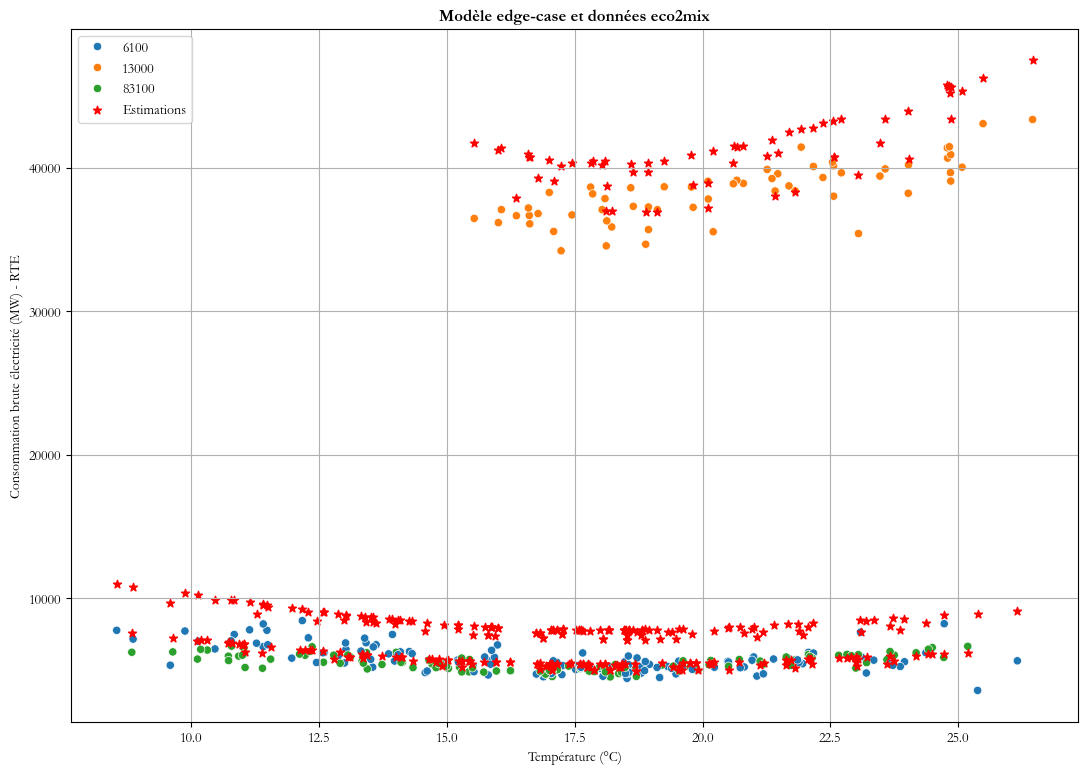

In [56]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

consos = pd.read_csv("data/consos_rte.csv")  # consos_rte0 pour avoir 2 villes et jusqu'au 13 mars en profondeur
consos = consos.sort_values(by="date")
estimations = pd.read_csv("data/estimations_conso.csv")    # estimations_conso0 poiur avoir jusqu'au 13 mars, 2 villes
estimations = estimations.sort_values(by="date")

# Retrieve hist
conso_hist = pd.read_csv("data/consos_rte0.csv")
conso_hist["consommation_mwh"] = conso_hist["consommation_mwh"] / 4   # Correction MW -> MWh à effectuer sur l'historique
consos = pd.concat([consos, conso_hist], axis = 0).sort_values(by = 'date', ascending = False)


data = consos.merge(estimations, on=["date", "id_metropole"])  # MERGE
data = data[data["missing_percentage"] < 5].reset_index()   # éviter les creux
# data = data[data["id_metropole"].isin([83100, 13000])].reset_index()

X_test_final = data[["temperature", "weekday"]]
y_test_final = data["consommation_mwh"]
y_pred = list(np.ones_like(y_test_final))
for i in range(len(data)):
    y_pred[i] = conso_paca(X_test_final["temperature"][i], X_test_final["weekday"][i]) * data["part_conso_metropole"][i]
rmsef = np.sqrt(mean_squared_error(y_test_final, y_pred))    
print(annee_min, annee_max)
print("RMSE finale : ", rmsef, "Soit ", rmsef / np.sqrt(np.mean(np.power(y_test_final, 2))))
print("Mean Absolute Error :", mean_absolute_error(y_test_final, y_pred), "Soit ", mean_absolute_error(y_test_final, y_pred) / y_test_final.mean())


# Tracer les points de données de test
plt.figure(figsize = (13, 9))
sns.scatterplot(x = "temperature" , y = "consommation_mwh", data = data, hue = "id_metropole", palette = "tab10")

# Tracer la courbe de la fonction
plt.scatter(X_test_final["temperature"], y_pred, color='red', label='Estimations', marker = "*")

plt.title('Modèle edge-case et données eco2mix', weight = 'bold')
plt.xlabel('Température (°C)')
plt.ylabel('Consommation brute électricité (MW) - RTE')
plt.legend()
plt.grid(True)
plt.show()


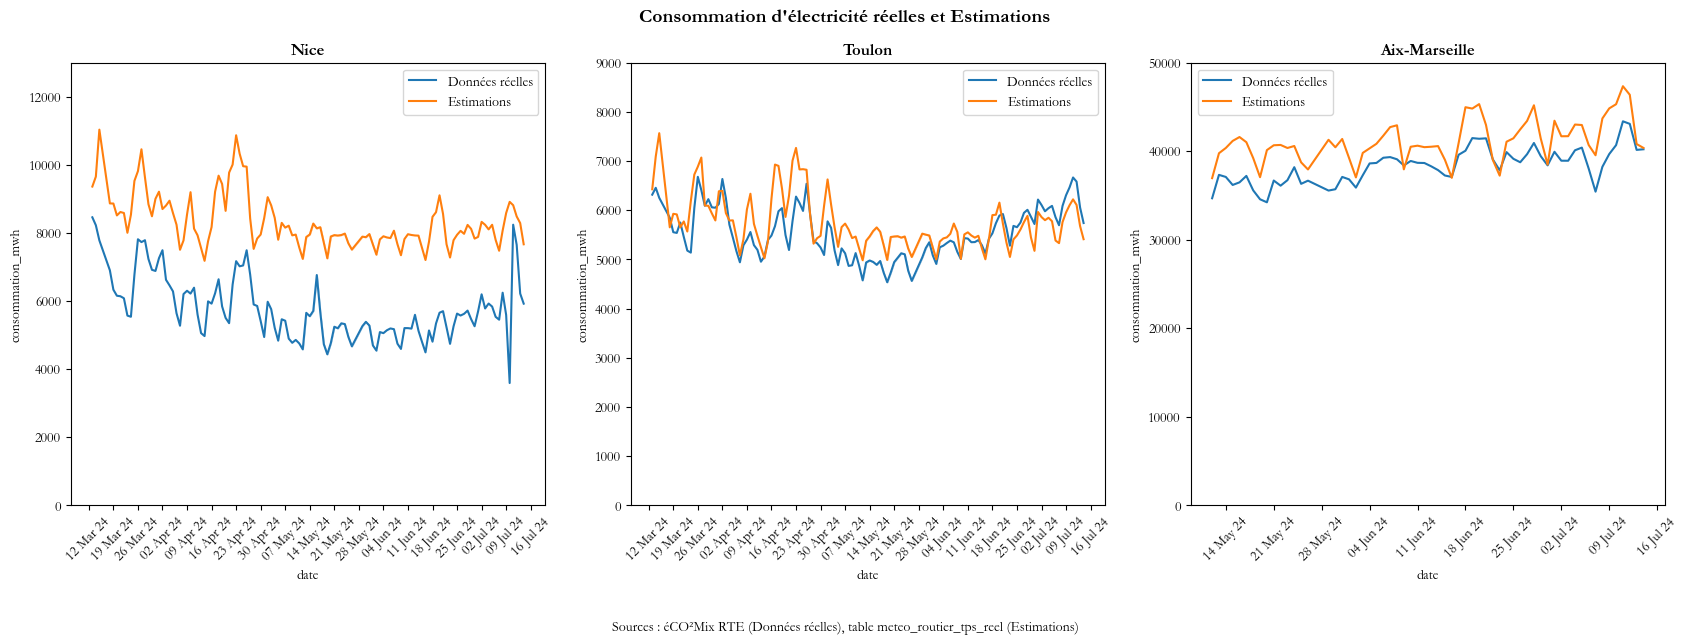

In [57]:
# Conversion de la colonne 'date' au format datetime
data['date'] = pd.to_datetime(data['date'])

# Filtrage des données pour Nice et Toulon
data_nice = data[data["id_metropole"] == 6100]
data_toulon = data[data["id_metropole"] == 83100]
data_axm = data[data["id_metropole"] == 13000]

# Création de la figure avec deux sous-graphiques
fig, ax = plt.subplots(1, 3, figsize=(17, 6))

# Graphe pour Nice
sns.lineplot(ax=ax[0], x='date', y="consommation_mwh", data=data_nice, label="Données réelles")
sns.lineplot(ax=ax[0], x='date', y="consommation_est_mwh", data=data_nice, label="Estimations")
ax[0].legend()
ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%d %b %y'))  # %b pour les abbréviations des mois
ax[0].xaxis.set_major_locator(mdates.WeekdayLocator())  # Afficher les étiquettes pour chaque mois
ax[0].tick_params(axis='x', rotation=45)  # Rotation des étiquettes
ax[0].set_ylim((0, 13000))
ax[0].set_title("Nice", weight='bold')

# Graphe pour Toulon
sns.lineplot(ax=ax[1], x='date', y="consommation_mwh", data=data_toulon, label="Données réelles")
sns.lineplot(ax=ax[1], x='date', y="consommation_est_mwh", data=data_toulon, label="Estimations")
ax[1].legend()
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%d %b %y'))  # %b pour les abbréviations des mois
ax[1].xaxis.set_major_locator(mdates.WeekdayLocator())  # Afficher les étiquettes pour chaque mois
ax[1].tick_params(axis='x', rotation=45)  # Rotation des étiquettes
ax[1].set_ylim((0, 9000))
ax[1].set_title("Toulon", weight='bold')
# Graphe pour Aix-M
sns.lineplot(ax=ax[2], x='date', y="consommation_mwh", data=data_axm, label="Données réelles")
sns.lineplot(ax=ax[2], x='date', y="consommation_est_mwh", data=data_axm, label="Estimations")
ax[2].legend()
ax[2].xaxis.set_major_formatter(mdates.DateFormatter('%d %b %y'))  # %b pour les abbréviations des mois
ax[2].xaxis.set_major_locator(mdates.WeekdayLocator())  # Afficher les étiquettes pour chaque mois
ax[2].tick_params(axis='x', rotation=45)  # Rotation des étiquettes
ax[2].set_ylim((0, 50000))
ax[2].set_title("Aix-Marseille", weight='bold')

fig.suptitle("Consommation d'électricité réelles et Estimations", weight='bold', fontsize=14)
fig.text(0.5, -0.05, "Sources : éCO²Mix RTE (Données réelles), table meteo_routier_tps_reel (Estimations)", 
         ha='center', va='center', fontsize=10)   # SOURCES
plt.tight_layout()
plt.show()

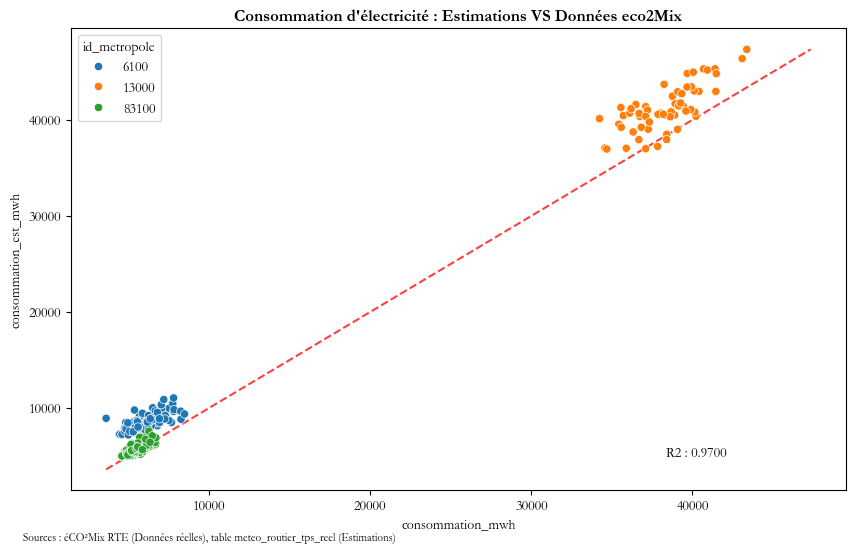

In [58]:
from sklearn.metrics import r2_score

plt.figure(figsize = (10, 6))

sns.scatterplot(data=data, x="consommation_mwh", y="consommation_est_mwh", hue = "id_metropole", palette='tab10')
# Calcul des limites de l'axe pour tracer y=x
lims = [
    min(data["consommation_mwh"].min(), data["consommation_est_mwh"].min()),  # Limite inférieure
    max(data["consommation_mwh"].max(), data["consommation_est_mwh"].max())   # Limite supérieure
]
# Tracé de la ligne y=x
plt.plot(lims, lims, 'r--', alpha=0.75, zorder=0)
# Affichage du graphique
plt.text(10000, -3500, "Sources : éCO²Mix RTE (Données réelles), table meteo_routier_tps_reel (Estimations)", 
         ha='center', va='center', fontsize=8)   # SOURCES
plt.text(data["consommation_mwh"].max() - 5000, data["consommation_est_mwh"].min(), f"R2 : {r2_score(data["consommation_mwh"], data["consommation_est_mwh"]):.4f}")
plt.title("Consommation d'électricité : Estimations VS Données eco2Mix", weight = 'bold')
plt.show()

In [30]:
print("Decalage initial entre données de test et d'entraînement : \n")
print("Conso moyenne à Nice de mars à juin 2024 : ", data.loc[data["id_metropole"] == 6100, "consommation_mwh"].mean())
print("Conso moyenne en Paca 2013-2023 * part_conso_metropole de Nice : ", df_mod["Consommation brute électricité (MW) - RTE"].mean() * 0.082989)

print("\nConso moyenne à Toulon de mars à juin 2024 : ", data.loc[data["id_metropole"] == 83100, "consommation_mwh"].mean())
print("Conso moyenne en Paca 2013-2023 * part_conso_metropole de Toulon : ", df_mod["Consommation brute électricité (MW) - RTE"].mean() * 0.0579)

print("\nConso moyenne à Aix-Mar de mars à juin 2024 : ", data.loc[data["id_metropole"] == 13000, "consommation_mwh"].mean())
print("Conso moyenne en Paca 2013-2023 * part_conso_metropole de Aix-Mar : ", df_mod["Consommation brute électricité (MW) - RTE"].mean() * 0.42937479)

Decalage initial entre données de test et d'entraînement : 

Conso moyenne à Nice de mars à juin 2024 :  5680.809917355372
Conso moyenne en Paca 2013-2023 * part_conso_metropole de Nice :  9232.553892340553

Conso moyenne à Toulon de mars à juin 2024 :  5358.533057851239
Conso moyenne en Paca 2013-2023 * part_conso_metropole de Toulon :  6441.394285586259

Conso moyenne à Aix-Mar de mars à juin 2024 :  37732.976744186046
Conso moyenne en Paca 2013-2023 * part_conso_metropole de Aix-Mar :  47768.088405540584


## fin